In [1]:
#importing packages for data manuplation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.express as px

#for easy access to path
import sys
import os

import warnings
warnings.filterwarnings('ignore')
import dvc.api

In [2]:
sys.path.append(os.path.abspath(os.path.join('data')))
sys.path.insert(0,'../scripts_/')

In [3]:
#import packages for machine learning operation
import scipy.stats as scs
import random
import math
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
from sklearn import tree
import scipy.stats as stat
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingClassifier

#import modules from script
from decision_tree import handler
from decision_tree import DecisionTreesModel
from XGboost import boost
from regression import Logistic
from helper import Helper

from app_logger import App_Logger

In [4]:
pd.set_option('max_column', None)
pd.set_option('max_rows', None)
#read csv file
df = pd.read_csv('../data/AdSmartABdata.csv')
df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [5]:
#Users who responded to the questionaries
answered_df = df.copy(deep=True)
answered_df = answered_df[answered_df['yes'] == 1].append(answered_df[answered_df['no'] == 1])

In [6]:
control_df = answered_df[answered_df['experiment'] == 'control']
exposed_df = answered_df[answered_df['experiment'] == 'exposed']


In [7]:
# Forming a combined DataFrame substituting the yes and no column to response and having only 1 and 0 as values where 1 translates to a yes and 0 to no
#All users who answered yes
all_yes_df = control_df[control_df['yes'] == 1].append(exposed_df[exposed_df['yes'] == 1])
all_yes_df = all_yes_df.drop(['yes','no'], axis = 1)
all_yes_df['response'] = 1
#All users who answered no
all_no_df = control_df[control_df['no'] == 1].append(exposed_df[exposed_df['no'] == 1])
all_no_df = all_no_df.drop(['yes','no'], axis = 1)
all_no_df['response'] = 0
#Final Combined dataframe will be
combined_df = all_yes_df.append(all_no_df)
combined_df = combined_df.sample(frac=1).reset_index(drop=True)
combined_df.head(5)

,auction_id,experiment,date,hour,device_make,platform_os,browser,response
0,343d34fc-6139-4405-894c-3974270b3667,exposed,2020-07-06,8,Generic Smartphone,6,Chrome Mobile,1
1,c080c340-5287-44b3-9469-ffc4b4889cec,exposed,2020-07-09,20,Generic Smartphone,6,Chrome Mobile,1
2,a12cd168-64d7-4b56-8313-718b961cc7da,exposed,2020-07-09,23,Generic Smartphone,6,Chrome Mobile,1
3,f46b1c92-8e6f-4f56-82ca-2c723d3ff397,control,2020-07-03,15,Samsung SM-J330FN,6,Samsung Internet,0
4,96a6556e-09aa-4d0f-8e62-48124e9a3be0,control,2020-07-09,12,Samsung SM-G950F,6,Facebook,1


>Extracting all who responded either yes or no to one column

### Encoding categorical variables using Label Encoder

In [8]:
def encode_labels(combined_df):
    date_encoder = preprocessing.LabelEncoder()
    device_encoder = preprocessing.LabelEncoder()
    browser_encoder = preprocessing.LabelEncoder()
    experiment_encoder = preprocessing.LabelEncoder()
    response_encoder = preprocessing.LabelEncoder()
    
    combined_df['date'] = date_encoder.fit_transform(combined_df['date'])
    combined_df['device_make'] = device_encoder.fit_transform(combined_df['device_make'])
    combined_df['browser'] = browser_encoder.fit_transform(combined_df['browser'])
    combined_df['experiment'] = experiment_encoder.fit_transform(combined_df['experiment'])
    combined_df['browser'] = response_encoder.fit_transform(combined_df['browser'])
    combined_df['response'] = response_encoder.fit_transform(combined_df['response'])


    
    return combined_df

In [9]:
combined_df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,response
0,343d34fc-6139-4405-894c-3974270b3667,exposed,2020-07-06,8,Generic Smartphone,6,Chrome Mobile,1
1,c080c340-5287-44b3-9469-ffc4b4889cec,exposed,2020-07-09,20,Generic Smartphone,6,Chrome Mobile,1
2,a12cd168-64d7-4b56-8313-718b961cc7da,exposed,2020-07-09,23,Generic Smartphone,6,Chrome Mobile,1
3,f46b1c92-8e6f-4f56-82ca-2c723d3ff397,control,2020-07-03,15,Samsung SM-J330FN,6,Samsung Internet,0
4,96a6556e-09aa-4d0f-8e62-48124e9a3be0,control,2020-07-09,12,Samsung SM-G950F,6,Facebook,1


## Modeling Training


In [10]:
def feature_data(cleaned_df):
    
    broweser_df = cleaned_df[["experiment", "hour", "date", 'device_make', 'browser', 'response']]
    platfrom_df = cleaned_df[["experiment", "hour", "date", 'device_make', 'platform_os', 'response']]

    return broweser_df, platfrom_df

In [11]:
def save_encoded_df(encoded_df):
    
    browser_df, platfrom_df = feature_data(encoded_df)
    browser_df.to_csv('../data/browser.csv', index=False)
    platfrom_df.to_csv('../data/platform.csv', index=False)

In [12]:
encoded_df = encode_labels(combined_df)
save_encoded_df(encoded_df)

In [13]:
browser_df= pd.read_csv("../data/browser.csv")
browser_df.head(5)

,experiment,hour,date,device_make,browser,response
0,1,8,3,13,1,1
1,1,20,6,13,1,1
2,1,23,6,13,1,1
3,0,15,0,81,7,0
4,0,12,6,66,4,1


In [14]:
df_platform= pd.read_csv("../data/platform.csv")
df_platform.head(5)

,experiment,hour,date,device_make,platform_os,response
0,1,8,3,13,6,1
1,1,20,6,13,6,1
2,1,23,6,13,6,1
3,0,15,0,81,6,0
4,0,12,6,66,6,1


#### Decision Tree

In [15]:
def read_model(self, file_name):
    with open(f"../models/{file_name}.pkl", "rb") as f:
        self.logger.info(f"Model loaded from {file_name}.pkl")
        return pickle.load(f)

def write_model(self, file_name):
    with open(f"../models/{file_name}.pkl", "wb") as f:
        self.logger.info(f"Model dumped to {file_name}.pkl")
        pickle.dump(model, f)


In [16]:
feature_cols = ["experiment", "hour", "date", 'device_make', 'browser']

X = browser_df[feature_cols]
y = browser_df[['response']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [17]:
decisionTreesModel = DecisionTreesModel(X_train, X_test,  y_train, y_test)

folds = 5
clf, acc_arr, loss_arr = decisionTreesModel.train(folds)


step 0: Validation Accuracy of DecisionTreesModel is: 0.545
step 0: Validation Loss of DecisionTreesModel is: 0.675

step 1: Validation Accuracy of DecisionTreesModel is: 0.509
step 1: Validation Loss of DecisionTreesModel is: 0.701

step 2: Validation Accuracy of DecisionTreesModel is: 0.536
step 2: Validation Loss of DecisionTreesModel is: 0.681

step 3: Validation Accuracy of DecisionTreesModel is: 0.583
step 3: Validation Loss of DecisionTreesModel is: 0.646

step 4: Validation Accuracy of DecisionTreesModel is: 0.516
step 4: Validation Loss of DecisionTreesModel is: 0.696



step 1: Test Accuracy of DecisionTreesModel is: 0.560
Test Metrics
              precision    recall  f1-score   support

           0       0.88      0.55      0.68       105
           1       0.20      0.60      0.30        20

    accuracy                           0.56       125
   macro avg       0.54      0.58      0.49       125
weighted avg       0.77      0.56      0.62       125

Loss on test data is: 0.663
Test accuracy on test data is: 0.560



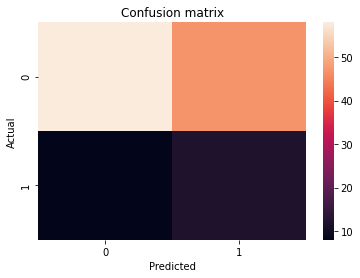

In [18]:
test_acc, loss, report, confusion_matrix = decisionTreesModel.test()
print(f"Loss on test data is: {loss:.3f}")
print(f"Test accuracy on test data is: {test_acc:.3f}")
print()

In [19]:
decisionTreesModel.get_feature_importance()

,feature,feature_importances
0,experiment,0.000000
1,hour,0.362719
2,date,0.163156
3,device_make,0.454362
4,browser,0.019764


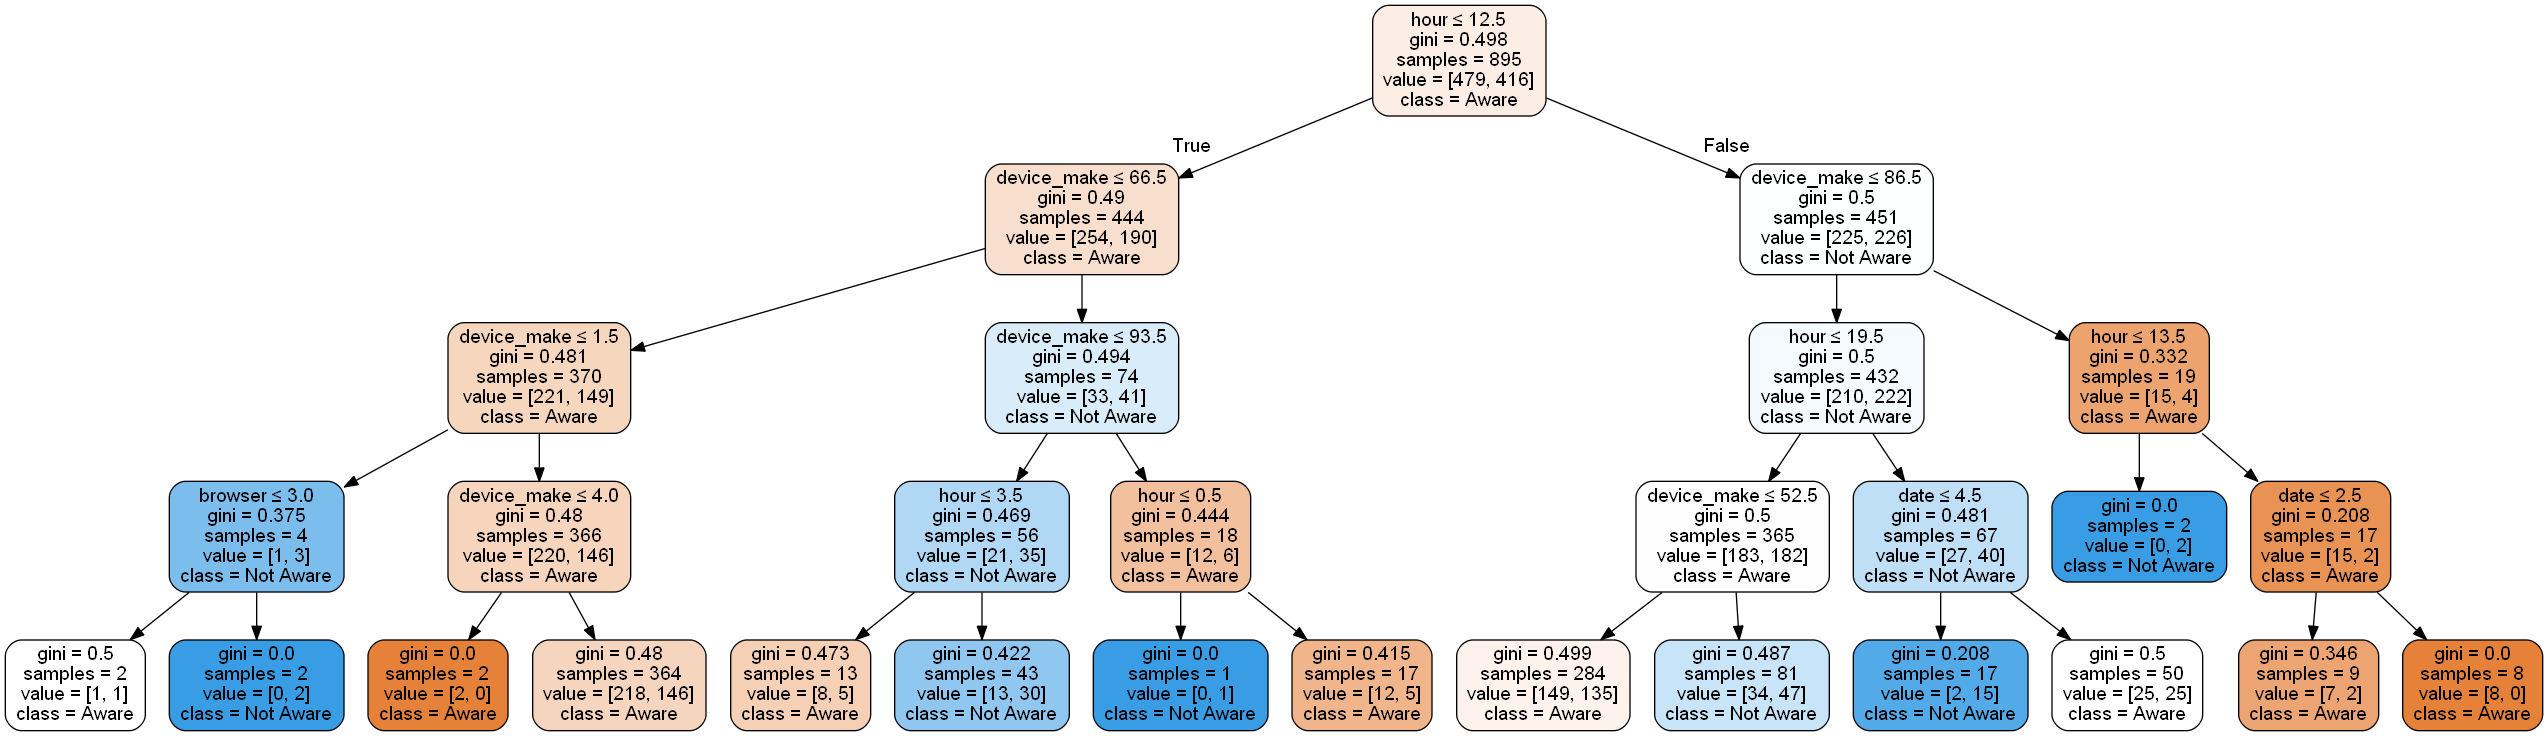

In [20]:
import pydotplus
#import graphviz
dot_data = StringIO()

leaves_parallel=False
feature_cols = ["experiment", "hour", "date", 'device_make', 'browser']
out_put_file = "AbTestDecisionTree.dot"

dot_data = export_graphviz(clf, out_file=out_put_file,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['Aware','Not Aware'])

graph = pydotplus.graphviz.graph_from_dot_file(out_put_file)
graph.write_png('AbTestDecisionTree.png')

Image(graph.create_png())

##### Decision tree by platform

In [23]:
feature_cols = ["experiment", "hour", "date", 'device_make', 'platform_os']

X = df_platform[feature_cols]
y = df_platform[['response']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [25]:
decisionTreesModel = DecisionTreesModel(X_train, X_test,  y_train, y_test)

folds = 5
clf, acc_arr, loss_arr = decisionTreesModel.train(folds)



step 0: Validation Accuracy of DecisionTreesModel is: 0.545
step 0: Validation Loss of DecisionTreesModel is: 0.675

step 1: Validation Accuracy of DecisionTreesModel is: 0.504
step 1: Validation Loss of DecisionTreesModel is: 0.704

step 2: Validation Accuracy of DecisionTreesModel is: 0.536
step 2: Validation Loss of DecisionTreesModel is: 0.681

step 3: Validation Accuracy of DecisionTreesModel is: 0.583
step 3: Validation Loss of DecisionTreesModel is: 0.646

step 4: Validation Accuracy of DecisionTreesModel is: 0.520
step 4: Validation Loss of DecisionTreesModel is: 0.693



step 1: Test Accuracy of DecisionTreesModel is: 0.560
Test Metrics
              precision    recall  f1-score   support

           0       0.88      0.55      0.68       105
           1       0.20      0.60      0.30        20

    accuracy                           0.56       125
   macro avg       0.54      0.58      0.49       125
weighted avg       0.77      0.56      0.62       125

Loss on test data is: 0.663



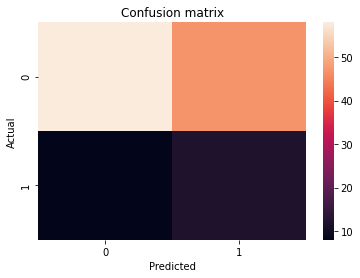

In [27]:
test_acc, loss, report, confusion_matrix = decisionTreesModel.test()
print(f"Loss on test data is: {loss:.3f}")
print()

In [28]:
decisionTreesModel.get_feature_importance()

,feature,feature_importances
0,experiment,0.000000
1,hour,0.382483
2,date,0.163156
3,device_make,0.454362
4,platform_os,0.000000


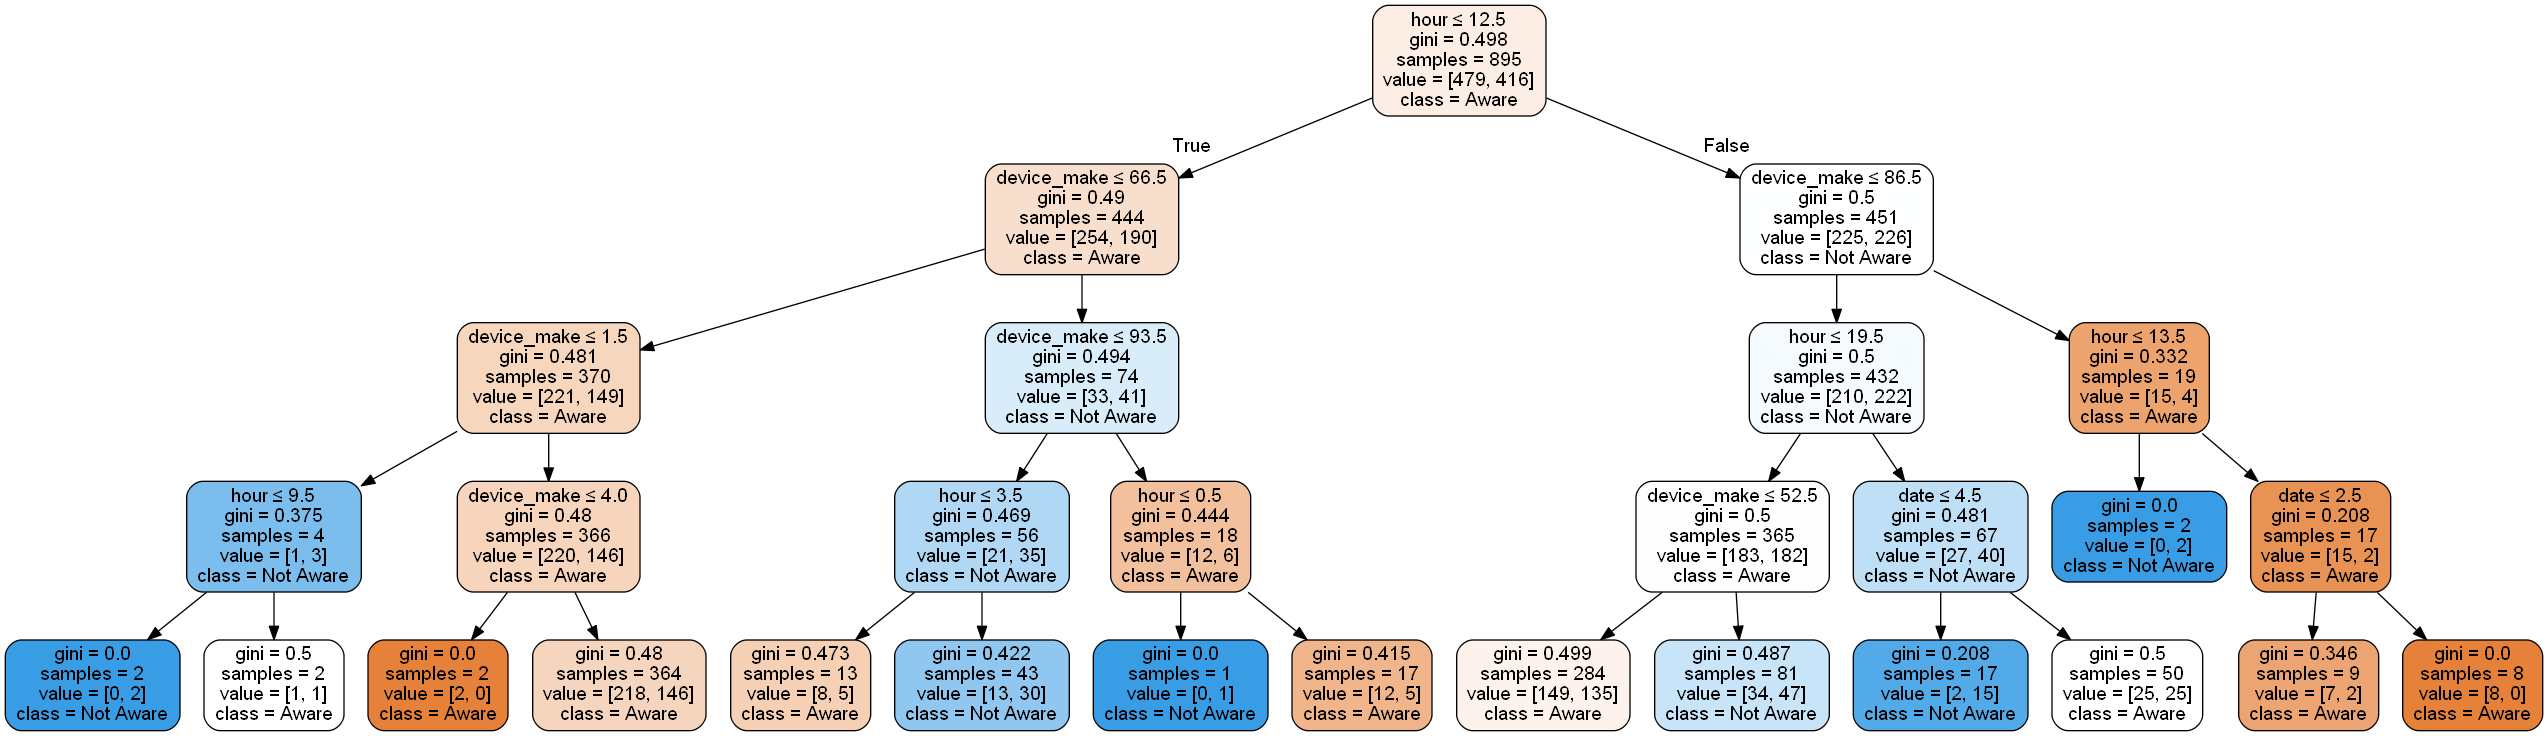

In [29]:
dot_data = StringIO()

leaves_parallel=False
feature_cols = ["experiment", "hour", "date", 'device_make', 'browser']
out_put_file = "AbTestDecisionTree.dot"

dot_data = export_graphviz(clf, out_file=out_put_file,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['Aware','Not Aware'])

graph = pydotplus.graphviz.graph_from_dot_file(out_put_file)
graph.write_png('AbTestDecisionTree.png')
Image(graph.create_png())